In [1]:
# common recipe to get access to the source inside src
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
##########################################################

import numpy as np
from pathlib import Path

from models.CaptionModalityClassifier import CaptionModalityClassifier # caption modality classifier
from dataset.MultilabelDataModule import MultilabelDataModule       # pytorch lightning data module for captions and images
from utils.caption_utils import load_glove_matrix                      # utils for embeddings

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

In [7]:
MAX_NUMBER_WORDS = 20000       # number of words to consider from embeddings vocabulary
MAX_WORDS_PER_SENTENCE = 500   # sentence maximum length
WORD_DIMENSION = 300           # number of features per embedding
NUM_CLASSES = 4                # 4 microscopy classes
NUM_FILTERS = 128              # number of filters use in the ConvText module

BASE_PATH = Path('/workspace/data')
DATA_PATH = BASE_PATH / 'multilabel-captions.csv'
EMBEDDINGS = BASE_PATH / 'embeddings'
OUTPUT_DIR = Path('./outputs')
BASE_IMG_DIR = BASE_PATH       # the image path in the CSV file are relative to this directory
BATCH_SIZE = 32
LR = 1e-4
PROJECT = 'biomedical-multimodal'

NUM_WORKERS = 72               # workers on the cluster, normally... 4?

The data module takes care of the preprocessing and creation of the dataloaders. We can now access the dataloaders using `train|val|test_dataloader()`, though this is handled internally by the trainer.

In [3]:
SEED = 43
TEST_SIZE = 0.2
dm = MultilabelDataModule(BATCH_SIZE,
                        str(DATA_PATH),
                        MAX_NUMBER_WORDS,
                        MAX_WORDS_PER_SENTENCE,
                        num_workers=NUM_WORKERS,
                        seed=SEED,
                        test_size=TEST_SIZE)
dm.prepare_data()
dm.setup()

print("Current vocabulary size: {0}".format(dm.vocab_size))
train_dataloader = dm.train_dataloader()
train_dataset    = train_dataloader.dataset

Current vocabulary size: 7967


Then, we need to handle the embeddings matrix.

In [4]:
if dm.vocab_size < MAX_NUMBER_WORDS:
    MAX_NUMBER_WORDS = dm.vocab_size

embeddings_matrix = load_glove_matrix(EMBEDDINGS, WORD_DIMENSION, MAX_NUMBER_WORDS, dm.word_index)

Dimension: 300; found 400000 word vectors.


In [5]:
MAX_NUMBER_WORDS

7967

## Train the model

In [3]:
model = CaptionModalityClassifier(
                 max_input_length=MAX_WORDS_PER_SENTENCE,
                 vocab_size=MAX_NUMBER_WORDS,
                 embedding_dim=WORD_DIMENSION,
                 filters=NUM_FILTERS,
                 embeddings=embeddings_matrix,
                 num_classes=NUM_CLASSES,
                 target_classes=None,
                 train_embeddings=True,
                 is_multilabel=True,
                 lr=LR)

# Creating the context for the weight and biases logger
wandb_logger = WandbLogger(project=PROJECT, tags=['nb', 'multi-label'])
wandb_logger.experiment.save()
print(wandb_logger.experiment.name)

output_run_path = OUTPUT_DIR / wandb_logger.experiment.name 
os.makedirs(output_run_path, exist_ok=False)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=5,
    verbose=True,
    mode='min'
)

#default_root_dir=str(output_run_path),
trainer = Trainer(gpus=1,
                  max_epochs=200,                  
                  early_stop_callback=early_stop_callback,
                  logger=wandb_logger)
trainer.fit(model, dm)
trainer.save_checkpoint(str(output_run_path / 'final.pt'))

NameError: name 'embeddings_matrix' is not defined

## Train the model with K Folds

In [4]:
SEED = 43
K_FOLDS = 5

dm = MultilabelDataModule(BATCH_SIZE,
                        str(DATA_PATH),
                        MAX_NUMBER_WORDS,
                        MAX_WORDS_PER_SENTENCE,
                        num_workers=NUM_WORKERS,
                        seed=SEED,
                        k_fold=K_FOLDS)
dm.prepare_data()

for k_fold_idx in np.arange(K_FOLDS):    
    wandb_logger = WandbLogger(project=PROJECT, tags=['nb', 'multi-label', 'k-fold'])
    wandb_logger.experiment.save()
    print(wandb_logger.experiment.name)
    run_name = print(wandb_logger.experiment.name)

    output_run_path = OUTPUT_DIR / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False)    
    
    dm.setup(k_fold_idx=k_fold_idx)
    if dm.vocab_size < MAX_NUMBER_WORDS:
        MAX_NUMBER_WORDS = dm.vocab_size
    embeddings_matrix = load_glove_matrix(EMBEDDINGS, WORD_DIMENSION, MAX_NUMBER_WORDS, dm.word_index)    
    print("K: {0}".format(k_fold_idx))
    print("Current vocabulary size: {0}".format(dm.vocab_size))
    
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode='min'
    )
    
    model = CaptionModalityClassifier(
                     max_input_length=MAX_WORDS_PER_SENTENCE,
                     vocab_size=MAX_NUMBER_WORDS,
                     embedding_dim=WORD_DIMENSION,
                     filters=NUM_FILTERS,
                     embeddings=embeddings_matrix,
                     num_classes=NUM_CLASSES,
                     target_classes=None,
                     train_embeddings=True,
                     is_multilabel=True,
                     lr=LR)    
    
    trainer = Trainer(gpus=1,
                  max_epochs=5,                  
                  early_stop_callback=early_stop_callback,
                  logger=wandb_logger)
    trainer.fit(model, dm)
    checkpoint_name = 'final.pt'
    trainer.save_checkpoint(str(output_run_path / checkpoint_name))    

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


desert-star-140
desert-star-140
Dimension: 300; found 400000 word vectors.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


K: 0
Current vocabulary size: 7888



  | Name    | Type            | Params
--------------------------------------------
0 | CNNText | CNNTextBackbone | 2 M   
1 | fc      | Linear          | 1 K   
2 | sigmoid | Sigmoid         | 0     


Saving latest checkpoint..


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


eager-cherry-141
eager-cherry-141
Dimension: 300; found 400000 word vectors.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | CNNText | CNNTextBackbone | 2 M   
1 | fc      | Linear          | 1 K   
2 | sigmoid | Sigmoid         | 0     


K: 1
Current vocabulary size: 7888


Saving latest checkpoint..


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


sandy-silence-142
sandy-silence-142
Dimension: 300; found 400000 word vectors.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | CNNText | CNNTextBackbone | 2 M   
1 | fc      | Linear          | 1 K   
2 | sigmoid | Sigmoid         | 0     


K: 2
Current vocabulary size: 7967


Saving latest checkpoint..


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fancy-oath-143
fancy-oath-143
Dimension: 300; found 400000 word vectors.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | CNNText | CNNTextBackbone | 2 M   
1 | fc      | Linear          | 1 K   
2 | sigmoid | Sigmoid         | 0     


K: 3
Current vocabulary size: 7869


Saving latest checkpoint..


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fast-lake-144
fast-lake-144
Dimension: 300; found 400000 word vectors.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | CNNText | CNNTextBackbone | 2 M   
1 | fc      | Linear          | 1 K   
2 | sigmoid | Sigmoid         | 0     


K: 4
Current vocabulary size: 7701


Saving latest checkpoint..


In [8]:
SEED = 443
dm = MultilabelDataModule(BATCH_SIZE,
                        str(DATA_PATH),
                        MAX_NUMBER_WORDS,
                        MAX_WORDS_PER_SENTENCE,
                        num_workers=NUM_WORKERS,
                        seed=SEED,
                        test_size=0,
                        k_fold=None)
dm.prepare_data()

In [9]:
wandb_logger = WandbLogger(project=PROJECT, tags=['nb', 'multi-label'])
wandb_logger.experiment.save()
print(wandb_logger.experiment.name)
run_name = print(wandb_logger.experiment.name)

output_run_path = OUTPUT_DIR / wandb_logger.experiment.name 
os.makedirs(output_run_path, exist_ok=False)    

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


bumbling-dragon-180
bumbling-dragon-180


In [10]:
dm.setup()
if dm.vocab_size < MAX_NUMBER_WORDS:
    MAX_NUMBER_WORDS = dm.vocab_size
print(MAX_NUMBER_WORDS)
embeddings_matrix = load_glove_matrix(EMBEDDINGS, WORD_DIMENSION, MAX_NUMBER_WORDS, dm.word_index)

8938
Dimension: 300; found 400000 word vectors.


In [11]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=5,
    verbose=True,
    mode='min'
)

model = CaptionModalityClassifier(
                 max_input_length=MAX_WORDS_PER_SENTENCE,
                 vocab_size=MAX_NUMBER_WORDS,
                 embedding_dim=WORD_DIMENSION,
                 filters=NUM_FILTERS,
                 embeddings=embeddings_matrix,
                 num_classes=NUM_CLASSES,
                 target_classes=None,
                 train_embeddings=True,
                 is_multilabel=True,
                 lr=LR)    

trainer = Trainer(gpus=1,
              max_epochs=70,
              num_sanity_val_steps=0,
              check_val_every_n_epoch=200,
              logger=wandb_logger)
trainer.fit(model, dm)
checkpoint_name = 'final.pt'
trainer.save_checkpoint(str(output_run_path / checkpoint_name)) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

  | Name    | Type            | Params
--------------------------------------------
0 | CNNText | CNNTextBackbone | 3 M   
1 | fc      | Linear          | 1 K   
2 | sigmoid | Sigmoid         | 0     


Saving latest checkpoint..


In [27]:
import torch
sentence1 = "this has a microscopy fluorescence image in it"
sentence2 = "this image contains some fluorescence and light stains, and there may be also some transmission examples. In particular DMFL"

tokenizer = dm.tokenizer
tokenizer

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

seqs = tokenizer.texts_to_sequences([sentence1, sentence2])
padded_seqs = pad_sequences(seqs, maxlen=300, padding='pre')
padded_seqs = torch.LongTensor(padded_seqs)

In [29]:
model.eval()
x = model(padded_seqs)
x

tensor([[0.3118, 0.5124, 0.1060, 0.2276],
        [0.1132, 0.4214, 0.2975, 0.2545]], grad_fn=<SigmoidBackward>)

## Test the model

Test uses the test_step and test_epoch_end functions on the model, and obtain the dataset from the test dataloader. Certainly, we can modify the dataloader to use the validation settings for test while experimenting.

In [13]:
type('st') == str

True

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Accuracy: 62.19931411743164
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(62.1993, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_acc': 62.19931411743164}]

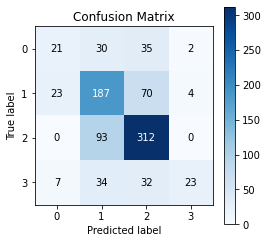

In [7]:
trainer.test(model)